# Node classification with Relational Graph Convolutional Network (RGCN)


<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/node-classification/rgcn-node-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/rgcn-node-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

This example demonstrates how use an RGCN [1] on the AIFB dataset with stellargraph. 

[1] Modeling Relational Data with Graph Convolutional Networks. Thomas N. Kipf, Michael Schlichtkrull (2017). https://arxiv.org/pdf/1703.06103.pdf

First we load the required libraries.

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.3.0b

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.3.0b")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.3.0b, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
from rdflib.extras.external_graph_libs import *
from rdflib import Graph, URIRef, Literal

import networkx as nx
from networkx.classes.function import info

import stellargraph as sg
from stellargraph.mapper import RelationalFullBatchNodeGenerator
from stellargraph.layer import RGCN

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

import sklearn
from sklearn import model_selection
from collections import Counter
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the data

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [4]:
dataset = datasets.AIFB()
display(HTML(dataset.description))
G, affiliation = dataset.load()

In [5]:
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 8285, Edges: 29043

 Node types:
  default: [8285]
    Features: float32 vector, length 8285
    Edge types: default-http://swrc.ontoware.org/ontology#abstract->default, default-http://swrc.ontoware.org/ontology#address->default, default-http://swrc.ontoware.org/ontology#author->default, default-http://swrc.ontoware.org/ontology#booktitle->default, default-http://swrc.ontoware.org/ontology#carriedOutBy->default, ... (40 more)

 Edge types:
    default-http://swrc.ontoware.org/ontology#publication->default: [4163]
    default-http://www.w3.org/1999/02/22-rdf-syntax-ns#type->default: [4124]
    default-http://swrc.ontoware.org/ontology#author->default: [3986]
    default-http://swrc.ontoware.org/ontology#isAbout->default: [2477]
    default-http://swrc.ontoware.org/ontology#name->default: [1302]
    default-http://swrc.ontoware.org/ontology#year->default: [1227]
    default-http://swrc.ontoware.org/ontology#title->default: [1227]
    default-ht

The relationship 'affiliation' indicates whether a researcher is affiliated with a research group e.g. (researcher, research group, affiliation). This is used to create the one-hot labels in the `affiliation` DataFrame. These relationships are not included in `G` (nor is its inverse relationship 'employs'). The idea here is to test whether we can recover a 'missing' relationship. 

## Input preparation

The nodes don't natively have features, so they've been replaced with one-hot indicators to allow the model to learn from the graph structure. We're only training on the people with affiliations, so we split that into train and test splits.

In [6]:
train_targets, test_targets = model_selection.train_test_split(
    affiliation, train_size=0.8, test_size=None
)

In [7]:
generator = RelationalFullBatchNodeGenerator(G, sparse=True)

train_gen = generator.flow(train_targets.index, targets=train_targets)
test_gen = generator.flow(test_targets.index, targets=test_targets)

## RGCN model creation and training

We use stellargraph to create an RGCN object. This creates a stack of relational graph convolutional layers. We add a softmax layer to transform the features created by RGCN into class predictions and create a Keras model.  Then we train the model on the stellargraph generators.

Each RGCN layer creates a weight matrix for each relationship in the graph. If `num_bases==0` these weight matrices are completely independent. If `num_bases!=0` each weight matrix is a different linear combination of the same basis matrices. This introduces parameter sharing and reduces the number of the parameters in the model.  See the paper for more details.

In [8]:
rgcn = RGCN(
    layer_sizes=[32, 32],
    activations=["relu", "relu"],
    generator=generator,
    bias=True,
    num_bases=20,
    dropout=0.5,
)

In [9]:
x_in, x_out = rgcn.in_out_tensors()
predictions = Dense(train_targets.shape[-1], activation="softmax")(x_out)
model = Model(inputs=x_in, outputs=predictions)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(0.01),
    metrics=["acc"],
)

In [10]:
history = model.fit(train_gen, validation_data=test_gen, epochs=20)

Epoch 1/20
1/1 [==============================] - 27s 27s/step - loss: 1.6109 - acc: 0.2746 - val_loss: 1.5623 - val_acc: 0.3611
Epoch 2/20
1/1 [==============================] - 23s 23s/step - loss: 1.5564 - acc: 0.5000 - val_loss: 1.4438 - val_acc: 0.4167
Epoch 3/20
1/1 [==============================] - 22s 22s/step - loss: 1.4328 - acc: 0.5070 - val_loss: 1.2094 - val_acc: 0.5000
Epoch 4/20
1/1 [==============================] - 21s 21s/step - loss: 1.2018 - acc: 0.5141 - val_loss: 0.9568 - val_acc: 0.6389
Epoch 5/20
1/1 [==============================] - 20s 20s/step - loss: 0.8872 - acc: 0.7606 - val_loss: 0.7373 - val_acc: 0.6944
Epoch 6/20
1/1 [==============================] - 20s 20s/step - loss: 0.7686 - acc: 0.8099 - val_loss: 0.5692 - val_acc: 0.7778
Epoch 7/20
1/1 [==============================] - 21s 21s/step - loss: 0.6025 - acc: 0.8662 - val_loss: 0.4802 - val_acc: 0.8889
Epoch 8/20
1/1 [==============================] - 21s 21s/step - loss: 0.4335 - acc: 0.8944 - val

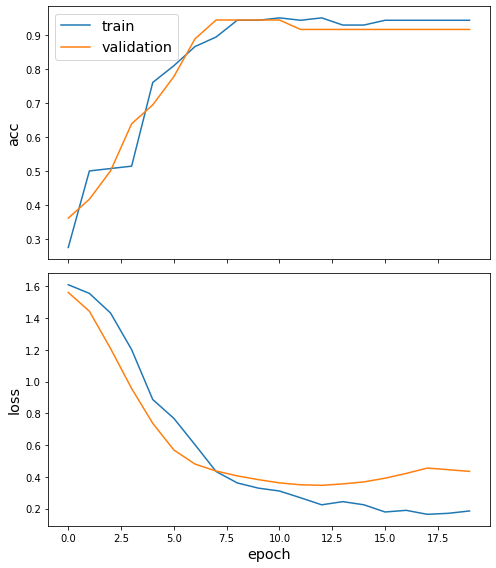

In [11]:
sg.utils.plot_history(history)

Now we assess the accuracy of our trained model on the test set - it does pretty well on this example dataset!

In [12]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 0.4342
	acc: 0.9167


## Node embeddings

We evaluate node embeddings as the activations of the output of the last graph convolution layer in the GCN layer stack and visualise them, coloring nodes by their true subject label. We expect to see nice clusters of researchers in the node embedding space, with researchers from the same group belonging to the same cluster.

To calculate the node embeddings rather than the class predictions, we create a new model with the same inputs as we used previously `x_inp` but now the output is the embeddings `x_out` rather than the predicted class. Additionally note that the weights trained previously are kept in the new model.

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# get embeddings for all people nodes
all_gen = generator.flow(affiliation.index, targets=affiliation)
embedding_model = Model(inputs=x_in, outputs=x_out)
emb = embedding_model.predict(all_gen)

In [14]:
X = emb.squeeze(0)
y = affiliation.idxmax(axis="columns").astype("category")

if X.shape[1] > 2:
    transform = TSNE

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=affiliation.index)
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=affiliation.index)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

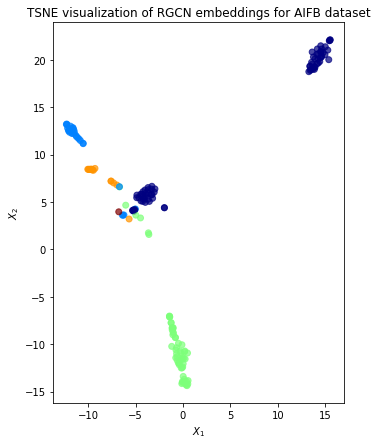

In [15]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].cat.codes,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of RGCN embeddings for AIFB dataset".format(transform.__name__)
)
plt.show()

Aside from a slight overlap the classes are well separated despite only using 2-dimensions. This indicates that our model is performing well at clustering the researchers into the right groups.

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/node-classification/rgcn-node-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/rgcn-node-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>